In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("../data/fish_data_after_depth.csv")

In [9]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, df, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = df["name"]
        self.targets = df["Length"]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        target = torch.tensor(self.targets[idx], dtype=torch.float32)
        return image, target

In [40]:
class CNN(nn.Module):
    def __init__(self, output_dim=1):  # Changed to output_dim for regression
        super(CNN, self).__init__()
        
        # First Convolutional Block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third Convolutional Block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 50 * 37, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, output_dim)
        
    def forward(self, x):
        # First block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Second block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Third block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(-1, 128 * 50 * 37)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [41]:
# Set up data transforms
transform = transforms.Compose([
    transforms.Resize((400, 300)),  # Resize images to 32x32
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
# Replace these paths with your actual data paths
train_dataset = CustomDataset(image_dir="../data/yolo_output/rotated_images", df=df, transform=transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

In [42]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(output_dim=1).to(device)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50

def train_model():
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, targets) in enumerate(train_loader):
            images = images.to(device)
            targets = targets.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                      f'Loss: {running_loss/100:.4f}')
                running_loss = 0.0

# Train the model
train_model()

/students/Hasan/fishometry/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Step [10/21], Loss: 6691.2714
Epoch [1/50], Step [20/21], Loss: 213.2040


/students/Hasan/fishometry/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Step [10/21], Loss: 154.6649
Epoch [2/50], Step [20/21], Loss: 128.2020
Epoch [3/50], Step [10/21], Loss: 147.9865
Epoch [3/50], Step [20/21], Loss: 130.3654
Epoch [4/50], Step [10/21], Loss: 133.9980
Epoch [4/50], Step [20/21], Loss: 139.4063
Epoch [5/50], Step [10/21], Loss: 130.1318
Epoch [5/50], Step [20/21], Loss: 146.2803
Epoch [6/50], Step [10/21], Loss: 139.2287
Epoch [6/50], Step [20/21], Loss: 130.8428
Epoch [7/50], Step [10/21], Loss: 142.2661
Epoch [7/50], Step [20/21], Loss: 134.1516
Epoch [8/50], Step [10/21], Loss: 133.6261
Epoch [8/50], Step [20/21], Loss: 152.1433
Epoch [9/50], Step [10/21], Loss: 130.3728
Epoch [9/50], Step [20/21], Loss: 130.0777
Epoch [10/50], Step [10/21], Loss: 138.6654
Epoch [10/50], Step [20/21], Loss: 119.6208
Epoch [11/50], Step [10/21], Loss: 129.7683
Epoch [11/50], Step [20/21], Loss: 133.6783
Epoch [12/50], Step [10/21], Loss: 139.8660
Epoch [12/50], Step [20/21], Loss: 141.5877
Epoch [13/50], Step [10/21], Loss: 123.1222
Epoc

In [57]:
train_model()
train_model()
train_model()
train_model()

/students/Hasan/fishometry/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Step [10/21], Loss: 123.3719
Epoch [1/50], Step [20/21], Loss: 125.5690


/students/Hasan/fishometry/.venv/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/50], Step [10/21], Loss: 133.2522
Epoch [2/50], Step [20/21], Loss: 125.4873
Epoch [3/50], Step [10/21], Loss: 133.0047
Epoch [3/50], Step [20/21], Loss: 129.2923
Epoch [4/50], Step [10/21], Loss: 138.7208
Epoch [4/50], Step [20/21], Loss: 124.0968
Epoch [5/50], Step [10/21], Loss: 129.0201
Epoch [5/50], Step [20/21], Loss: 131.4239
Epoch [6/50], Step [10/21], Loss: 134.4393
Epoch [6/50], Step [20/21], Loss: 134.3688
Epoch [7/50], Step [10/21], Loss: 119.8489
Epoch [7/50], Step [20/21], Loss: 129.5481
Epoch [8/50], Step [10/21], Loss: 129.0804
Epoch [8/50], Step [20/21], Loss: 109.3504
Epoch [9/50], Step [10/21], Loss: 123.9769
Epoch [9/50], Step [20/21], Loss: 134.8240
Epoch [10/50], Step [10/21], Loss: 136.8625
Epoch [10/50], Step [20/21], Loss: 114.7221
Epoch [11/50], Step [10/21], Loss: 143.4433
Epoch [11/50], Step [20/21], Loss: 123.6692
Epoch [12/50], Step [10/21], Loss: 135.7542
Epoch [12/50], Step [20/21], Loss: 138.2332
Epoch [13/50], Step [10/21], Loss: 144.7795
Epoc

In [58]:
model.eval()

pred = []
real = []
with torch.no_grad():
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        outputs = model(images)
        pred.extend(outputs.cpu().numpy())
        real.extend(targets.cpu().numpy())
pred = np.array(pred)
real = np.array(real)

MAPE: 23.775024712085724


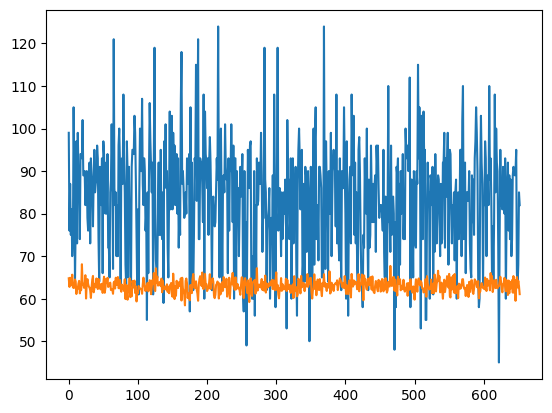

In [59]:
print("MAPE:", mean_absolute_percentage_error(real, pred) * 100)
plt.plot(real)
plt.plot(pred)
plt.show()